# Autograd Tutorial

References:

* R. Grosse' NN and ML course: https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/
* Backpropagation notes from Stanford's CS231n: http://cs231n.github.io/optimization-2/
* Autograd Github Repository (contains a tutorial and examples): https://github.com/HIPS/autograd

## Recall: Approaches for Computing Derivatives

* **Symbolic differentiation:** automatic manipulation of mathematical expressions to get derivatives
    - Takes a math expression and returns a math expression: $f(x) = x^2 \rightarrow \frac{df(x)}{dx} = 2x$
    - Used in Mathematica, Maple, Sympy, etc.
* **Numeric differentiation:** Approximating derivatives by finite differences:
$$
\frac{\partial}{\partial x_i} f(x_1, \dots, x_N) = \lim_{h \to 0} \frac{f(x_1, \dots, x_i + h, \dots, x_N) - f(x_1, \dots, x_i - h, \dots, x_N)}{2h}
$$
* **Automatic differentiation:** Takes code that computes a function and returns code that computes the derivative of that function.
    - Reverse Mode AD: A method to get exact derivatives efficiently, by storing information as you go forward that you can reuse as you go backwards
    - "The goal isn't to obtain closed-form solutions, but to be able to wirte a program that efficiently computes the derivatives." 
    - **Autograd**, **Torch Autograd**

## Reverse Mode Automatic Differentiation

In machine learning, we have functions that have large fan-in, e.g. a neural net can have millions of parameters, that all squeeze down to one scalar that tells you how well it predicts something. eg. cats...

### General Idea for Implementation

* Create a "tape" data structure that tracks the operations performed in computing a function
* Overload primitives to:
    - Add themselves to the tape when called
    - Compute gradients with respect to their local inputs
* _Forward pass_ computes the function, and adds operations to the tape
* _Reverse pass_ accumulates the local gradients using the chain rule
* This is efficient for graphs with large fan-in, like most loss functions in ML

## Autograd

* [Autograd](https://github.com/HIPS/autograd) is a Python package for automatic differentiation.
* To install Autograd:
                pip install autograd
* There are a lot of great [examples](https://github.com/HIPS/autograd/tree/master/examples) provided with the source code

### What can Autograd do?

From the Autograd Github repository:

* Autograd can automatically differentiate native Python and Numpy code.
* It can handle a large subset of Python's features, including loops, conditional statements (if/else), recursion and closures
* It can also compute higher-order derivatives
* It uses reverse-mode differentiation (a.k.a. backpropagation) so it can efficiently take gradients of scalar-valued functions with respect to array-valued arguments.


## Autograd Basic Usage

In [2]:
import autograd.numpy as np # Import thinly-wrapped numpy
from autograd import grad   # Basicallly the only function you need

In [3]:
# Define a function as usual, using Python and Numpy
def tanh(x):
    y = np.exp(-x)
    return (1.0 - y) / (1.0 + y)

# Create a *function* that computes the gradient of tanh
grad_tanh = grad(tanh)

# Evaluate the gradient at x = 1.0
print(grad_tanh(1.0))

# Compare to numeric gradient computed using finite differences
print((tanh(1.0001) - tanh(0.9999)) / 0.0002)

0.39322386648296376
0.39322386636453377


## Autograd vs Manual Gradients via Staged Computation

In this example, we will see how a complicated computation can be written as a composition of simpler functions, and how this provides a scalable strategy for computing gradients using the chain rule.

We want to write a function to compute the gradient of the *sigmoid function*:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$
We can write $\sigma(x)$ as a composition of several elementary functions, as $\sigma(x) = s(c(b(a(x))))$, where

$$
\begin{align}
a(x) &= -x \\
b(a) & = e^a \\
c(b) & = 1 + b \\
s(c) = \frac{1}{c}.
\end{align}
$$

Here, we have "staged" the computation such that it contains several intermediate variables, each of which are **basic expressions** for which we can easily compute the local gradients.

The computation graph for this expression is 

$$ x \longrightarrow a \longrightarrow b \longrightarrow c \longrightarrow  s.$$

The input to this function is $x$, and the output is represented by node $s$. We want to compute the gradient of $s$ with respect to $x$, $$\frac{\partial s}{\partial x}.$$ In order to make use of our intermediate computations, we  just use the chain rule,
$$
\frac{\partial s}{\partial x} = \frac{\partial s}{\partial c} \frac{\partial c}{\partial b} \frac{\partial b}{\partial a} \frac{\partial a}{\partial x},
$$
where we clearly observe the backward propagation of the gradients, from $s$ to $a.$


> Given a vector-to-scalar function, $\mathbb{R}^D \to \mathbb{R}$, composed of a set of primitive functions
$\mathbb{R}^M \to \mathbb{R}^N$ (for various $M$, $N$), the gradient of the composition is given by the product of the gradients of the primitive functions, according to the chain rule. But the chain rule doesn’t prescribe the order in which to multiply the gradients. From the perspective of computational complexity, the order makes all the difference.


In [4]:
def grad_sigmoid_manual(x):
    """Implements the gradient of the logistic sigmoid function 
    $\sigma(x) = 1 / (1 + e^{-x})$ using staged computation
    """
    # Forward pass, keeping track of intermediate values for use in the 
    # backward pass
    a = -x         # -x in denominator
    b = np.exp(a)  # e^{-x} in denominator
    c = 1 + b      # 1 + e^{-x} in denominator
    s = 1.0 / c    # Final result: 1.0 / (1 + e^{-x})
    
    # Backward pass (differentiate basic functions)
    dsdc = (-1.0 / (c**2))
    dsdb = dsdc * 1
    dsda = dsdb * np.exp(a)
    dsdx = dsda * (-1)
    
    return dsdx


def sigmoid(x):
    y = 1.0 / (1.0 + np.exp(-x))
    return y

# Instead of writing grad_sigmoid_manual manually, we can use 
# Autograd's grad function:
grad_sigmoid_automatic = grad(sigmoid)

# Compare the results of manual and automatic gradient functions:
print(grad_sigmoid_automatic(2.0))
print(grad_sigmoid_manual(2.0))

0.1049935854035065
0.1049935854035065


## Gradient Functions

There are several functions that compute gradients, which have different signatures

* `grad(fun, argnum=0)`
    - Returns a function which computes the gradient of `fun` with respect to
      positional argument number `argnum`. The returned function takes the same
      arguments as `fun`, but returns the gradient instead. The function `fun`
      should be scalar-valued. The gradient has the same type as the argument.
* `grad_named(fun, argname)`
    - Takes gradients with respect to a named argument.
* `multigrad(fun, argnums=[0])`
    - Takes gradients wrt multiple arguments simultaneously.
* `multigrad_dict(fun)`
    - Takes gradients with respect to all arguments simultaneously, and returns a dict mapping `argname` to `gradval`

## Modularity: Implementing Custom Gradients

The implementation of Autograd is simple, readable, and extensible!

One thing you can do is define custom gradients for your own functions. There are several reasons you might want to do this, including:

1. **Speed:** You may know a faster way to compute the gradient for a specific function.
2. **Numerical Stability**
3. When your code depends on **external library calls**

The `@primitive` decorator wraps a function so that its gradient can be specified manually and its invocation can be recorded.

In [6]:
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.extend import primitive, defvjp

# From the Autograd examples:
# @primitive tells autograd not to look inside this function, but instead
# to treat it as a black box, whose gradient might be specified later.
@primitive
def logsumexp(x):
    """Numerically stable log(sum(exp(x)))"""
    max_x = np.max(x)
    return max_x + np.log(np.sum(np.exp(x - max_x)))

# Next, we write a function that specifies the gradient with a closure.
def make_grad_logsumexp(ans, x):
    # If you want to be able to take higher-order derivatives, then all the
    # code inside this function must be itself differentiable by autograd.
    def gradient_product(g):
        return np.full(x.shape, g) * np.exp(x - np.full(x.shape, ans))
    return gradient_product

# Now we tell autograd that logsumexmp has a gradient-making function.
defvjp(logsumexp, make_grad_logsumexp)

In [7]:
# Now we can use logsumexp() inside a larger function that we want to differentiate.
def example_func(y):
    z = y**2
    lse = logsumexp(z)
    return np.sum(lse)

grad_of_example = grad(example_func)
print("Gradient: ", grad_of_example(npr.randn(10)))

# Check the gradients numerically, just to be safe.
# Fails if a mismatch occurs
from autograd.test_util import check_grads
check_grads(example_func, modes=['rev'], order=2)(npr.randn(10))

Gradient:  [ 0.00445388 -0.06760237 -0.0030408  -0.00398812  0.13980291 -0.65753857
 -0.57149671 -0.0969613  -0.27697817  1.59207253]


# Examples

The next three sections of the notebook show examples of using Autograd in the context of three problems:

1. **1-D linear regression**, where we try to fit a model to a function $y = wx + b$
2. **Linear regression using a polynomial feature map**, to fit a function of the form $y = w_0 + w_1 x + w_2 x^2 + \dots + w_M x^M$
3. **Nonlinear regression using a neural network**

## Linear Regression

### Review

We are given a set of data points $\{ (x_1, t_1), (x_2, t_2), \dots, (x_N, t_N) \}$, where each point $(x_i, t_i)$ consists of an *input value* $x_i$ and a *target value* $t_i$. 

The **model** we use is:
$$
y_i = wx_i + b
$$

We want each predicted value $y_i$ to be close to the ground truth value $t_i$. In linear regression, we use squared error to quantify the disagreement between $y_i$ and $t_i$. The **loss function** for a single example is:
$$
\mathcal{L}(y_i,t_i) = \frac{1}{2} (y_i - t_i)^2
$$

The **cost function** is the loss averaged over all the training examples:
$$
\mathcal{E}(w,b) = \frac{1}{N} \sum_{i=1}^N \mathcal{L}(y_i, t_i) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \left(wx_i + b - t_i \right)^2
$$

In [8]:
import autograd.numpy as np # Import wrapped NumPy from Autograd
import autograd.numpy.random as npr # For convenient access to numpy.random
from autograd import grad # To compute gradients

import matplotlib.pyplot as plt # For plotting

%matplotlib inline

## Generate Synthetic Data

We generate a synthetic dataset $\{ (x_i, t_i) \}$ by first taking the $x_i$ to be linearly spaced in the range $[0, 10]$ and generating the corresponding value of $t_i$ using the following equation (where $w = 4$ and $b=10$):
$$
t_i = 4 x_i + 10 + \epsilon
$$

Here, $\epsilon \sim \mathcal{N}(0, 2),$ that is, $\epsilon$ is drawn from a Gaussian distribution with mean 0 and variance 2. This introduces some random fluctuation in the data, to mimic real data that has an underlying regularity, but for which individual observations are corrupted by random noise.


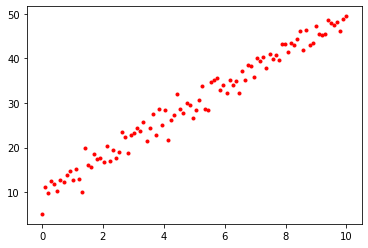

In [9]:
# In our synthetic data, we have w = 4 and b = 10
N = 100 # Number of training data points
x = np.linspace(0, 10, N)
t = 4 * x + 10 + npr.normal(0, 2, x.shape[0])
plt.plot(x, t, 'r.')

In [10]:
# Initialize random parameters
w = npr.normal(0, 1)
b = npr.normal(0, 1)
params = { 'w': w, 'b': b } # One option: aggregate parameters in a dictionary

def cost(params):
    y = params['w'] * x + params['b']
    return (1 / N) * np.sum(0.5 * np.square(y - t))

# Find the gradient of the cost function using Autograd
grad_cost = grad(cost) 

num_epochs = 1000  # Number of epochs of training
alpha = 0.01       # Learning rate

for i in range(num_epochs):
    # Evaluate the gradient of the current parameters stored in params
    cost_params = grad_cost(params)
    
    # Update parameters w and b
    params['w'] = params['w'] - alpha * cost_params['w']
    params['b'] = params['b'] - alpha * cost_params['b']

print(params)

{'w': 4.084961144270687, 'b': 9.264915086528749}


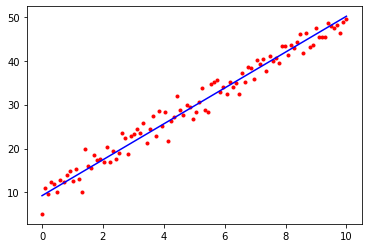

In [11]:
# Plot the training data, together with the line defined by y = wx + b,
# where w and b are our final learned parameters
plt.plot(x, t, 'r.')
plt.plot([0, 10], [params['b'], params['w'] * 10 + params['b']], 'b-')
plt.show()

## Linear Regression with a Feature Mapping

In this example we will fit a polynomial using linear regression with a polynomial feature mapping.
The target function is

$$
t = x^4 - 10 x^2 + 10 x + \epsilon,
$$

where $\epsilon \sim \mathcal{N}(0, 4).$

This is an example of a _generalized linear model_, in which we perform a fixed nonlinear transformation of the inputs $\mathbf{x} = (x_1, x_2, \dots, x_D)$, and the model is still linear in the _parameters_. We can define a set of _feature mappings_ (also called feature functions or basis functions) $\phi$ to implement the fixed transformations.

In this case, we have $x \in \mathbb{R}$, and we define the feature mapping:
$$
\mathbf{\phi}(x) = \begin{pmatrix}\phi_1(x) \\ \phi_2(x) \\ \phi_3(x) \\ \phi_4(x) \end{pmatrix} = \begin{pmatrix}1\\x\\x^2\\x^3\end{pmatrix}
$$

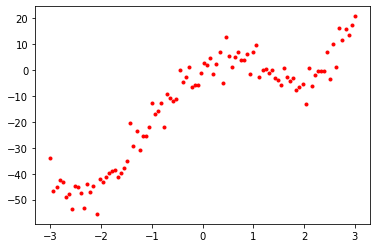

In [12]:
# Generate synthetic data
N = 100 # Number of data points
x = np.linspace(-3, 3, N) # Generate N values linearly-spaced between -3 and 3
t = x ** 4 - 10 * x ** 2 + 10 * x + npr.normal(0, 4, x.shape[0]) # Generate corresponding targets
plt.plot(x, t, 'r.') # Plot data points

In [13]:
M = 4 # Degree of polynomial to fit to the data (this is a hyperparameter)
feature_matrix = np.array([[item ** i for i in range(M+1)] for item in x]) # Construct a feature matrix 
W = npr.randn(feature_matrix.shape[-1])

def cost(W):
    y = np.dot(feature_matrix, W)
    return (1.0 / N) * np.sum(0.5 * np.square(y - t))

# Compute the gradient of the cost function using Autograd
cost_grad = grad(cost)

num_epochs = 10000
learning_rate = 0.001

# Manually implement gradient descent
for i in range(num_epochs):
    W = W - learning_rate * cost_grad(W)

# Print the final learned parameters.
print(W)

[  0.0545782   10.42891793 -10.10707337  -0.03126282   1.02186303]


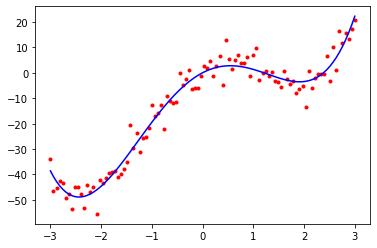

In [15]:
# Plot the original training data again, together with the polynomial we fit
plt.plot(x, t, 'r.')
plt.plot(x, np.dot(feature_matrix, W), 'b-')
plt.show()

## Neural Net Regression

In this example we will implement a (nonlinear) regression model using a neural network. 

To implement and train a neural net using Autograd, you only have to define the forward pass of the network and the loss function you wish to use; you do _not_ need to implement the _backward pass_ of the network. When you take the gradient of the loss function using `grad`, Autograd automatically computes 
the backward pass. It essentially executes the backpropagation algorithm implicitly.


In [16]:
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc import flatten #, flatten_func

from autograd.misc.optimizers import sgd

%matplotlib inline

### Autograd Implementation of Stochastic Gradient Descent (with momentum)

```
def sgd(grad, init_params, callback=None, num_iters=200, step_size=0.1, mass=0.9):
    """Stochastic gradient descent with momentum.
    grad() must have signature grad(x, i), where i is the iteration number."""
    flattened_grad, unflatten, x = flatten_func(grad, init_params)
    
    velocity = np.zeros(len(x))
    for i in range(num_iters):
        g = flattened_grad(x, i)
        if callback:
            callback(unflatten(x), i, unflatten(g))
        velocity = mass * velocity - (1.0 - mass) * g
        x = x + step_size * velocity
    return unflatten(x)
```

The next example shows how to use the `sgd` function.

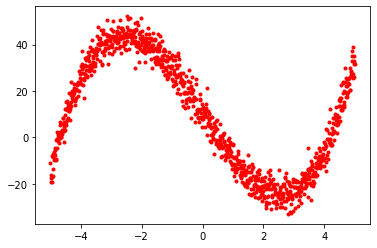

In [17]:
# Generate synthetic data
x = np.linspace(-5, 5, 1000)
t = x ** 3 - 20 * x + 10 + npr.normal(0, 4, x.shape[0])
plt.plot(x, t, 'r.')

307.27526955036535
{'W1': array([[-2.94559997,  0.16121652, -1.30047875, -1.22974889]]), 'b1': array([-5.28166397, -0.82528464,  2.41753918,  6.14589224]), 'W2': array([[-5.05168877e-01, -2.36611718e+00, -3.27880077e+00,
         2.75007753e+00],
       [-1.92904027e-01, -2.37367667e-01, -4.65899580e-01,
        -1.92235478e+00],
       [ 4.09549644e-01, -2.22665262e+00,  1.40462107e+00,
         2.85735187e-03],
       [-3.72648981e+00,  2.46773804e+00,  1.86232133e+00,
        -1.55498882e+00]]), 'b2': array([ 5.30739445,  0.42395663, -4.68675653, -2.42712697]), 'W3': array([[ 6.08166514],
       [-3.52731677],
       [ 4.50279179],
       [-3.36406041]]), 'b3': array([0.11658614])}
8.641052001438881


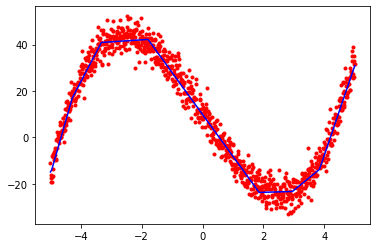

In [23]:
inputs = x.reshape(x.shape[-1],1)
W1 = npr.randn(1,4)
b1 = npr.randn(4)
W2 = npr.randn(4,4)
b2 = npr.randn(4)
W3 = npr.randn(4,1)
b3 = npr.randn(1)

params = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3 }

def relu(x):
    return np.maximum(0, x)

#nonlinearity = np.tanh
nonlinearity = relu

def predict(params, inputs):
    h1 = nonlinearity(np.dot(inputs, params['W1']) + params['b1'])
    h2 = nonlinearity(np.dot(h1, params['W2']) + params['b2'])
    output = np.dot(h2, params['W3']) + params['b3']
    return output

def loss(params, i):
    output = predict(params, inputs)
    return (1.0 / inputs.shape[0]) * np.sum(0.5 * np.square(output.reshape(output.shape[0]) - t))

print(loss(params, 0))

optimized_params = sgd(grad(loss), params, step_size=0.01, num_iters=5000)
print(optimized_params)
print(loss(optimized_params, 0))

final_y = predict(optimized_params, inputs)
plt.plot(x, t, 'r.')
plt.plot(x, final_y, 'b-')
plt.show()

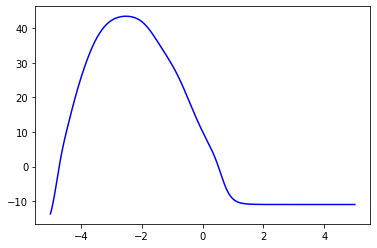

In [19]:
# A plot of the result of this model using tanh activations
plt.plot(x, final_y, 'b-')
plt.show()

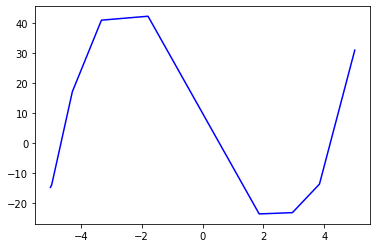

In [24]:
# A plot of the result of this model using ReLU activations
plt.plot(x, final_y, 'b-')
plt.show()